## 导入库

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
import os,PIL,pathlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 安装wandb

Weights & Biases 可以帮助跟踪你的机器学习项目。使用我们的工具记录运行中的超参数和输出指标(Metric)，然后对结果进行可视化和比较，并快速与同事分享你的发现。

wandb是一个免费的，用于记录实验数据的工具。wandb相比于tensorboard之类的工具，有更加丰富的用户管理，团队管理功能，更加方便团队协作。使用wandb首先要在网站上创建team，然后在team下创建project，然后project下会记录每个实验的详细数据。

In [2]:
!pip install wandb

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: quincyqiang (use `wandb login --relogin` to force relogin)


True

In [4]:
run = wandb.init(project="基于VGG进行天气识别",reinit="True")

wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## 加载数据集

In [5]:
data_dir = 'data/weather_photos/'
train_transforms  = transforms.Compose([
    transforms.Resize([128, 128]),  # 将输入图片resize成统一尺寸
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的。
])
############这里尝试做过灰度显示以后进行训练，但是结果是不如人意的，增加模型层数也达不到90%的进度，只能到88%左右，通过图片也能看出来，如果没有颜色的话，shine和sunrise其实还是不好判断的。


dataset = datasets.ImageFolder(data_dir,transform=train_transforms)
print(dataset.classes)
print(len(dataset))

['cloudy', 'rain', 'shine', 'sunrise']
1125


展示几张天气图片

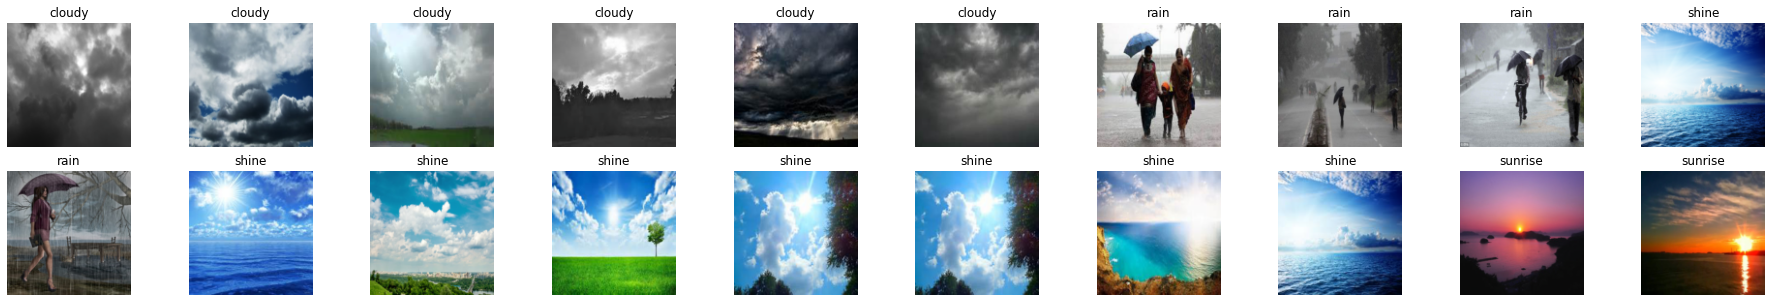

In [6]:
import matplotlib.pyplot as plt
import numpy as np
means=[0.485, 0.456, 0.406]
stds=[0.229, 0.224, 0.225]
plt.figure(figsize=(32,5))
for i in range(20):
    k =  np.random.randint(40,60)
    img = dataset[k*i+i][0].numpy().transpose((1,2,0))
    img = img*stds + means
    img = np.clip(img, 0, 1)
    plt.subplot(2, 10, i+1)
    plt.imshow(img,cmap = plt.cm.gray_r)
    # 增加对应图片的标题
    plt.title(dataset.classes[dataset[k*i+i][1]])
    plt.axis('off')

划分数据集，得到训练集和测试集

In [7]:
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x1f85f441370>,
 <torch.utils.data.dataset.Subset at 0x1f85af89130>)

In [8]:
train_size,test_size


(900, 225)

In [9]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [10]:
for X, y in test_dl:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 128, 128])
Shape of y:  torch.Size([32]) torch.int64


In [29]:
dataset.classes

['cloudy', 'rain', 'shine', 'sunrise']

## 定义CNN网络

In [11]:
import torch.nn.functional as F

class Network_bn(nn.Module):
    def __init__(self):
        super(Network_bn, self).__init__()
        """
        nn.Conv2d()函数：
        第一个参数（in_channels）是输入的channel数量
        第二个参数（out_channels）是输出的channel数量
        第三个参数（kernel_size）是卷积核大小
        第四个参数（stride）是步长，默认为1
        第五个参数（padding）是填充大小，默认为0
        """

        self.conv0 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=1)  #24*128*128
        self.bn0 = nn.BatchNorm2d(24)
        self.conv1 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5, stride=2, padding=1)  #48*62*62
        self.bn1 = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)   #48*62*62
        self.bn2 = nn.BatchNorm2d(48)
        self.pool1 = nn.MaxPool2d(2,2)       #48*31*31
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=2, padding=0)   #96*14*14
        self.bn3 = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=1, stride=1, padding=0)   #96*14*14
        self.bn4 = nn.BatchNorm2d(96)
        self.pool2 = nn.MaxPool2d(2,2)       #48*7*7
        self.conv5 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=1, stride=1, padding=0)   #128*7*7
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0)   #128*7*7
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2,2)       #128*3*3
        self.fc =nn.Sequential(nn.Flatten(), nn.Linear(128*3*3, 516), nn.ReLU(inplace=True), nn.Dropout(0.5), 
        nn.Linear( 516,124), nn.ReLU(inplace=True), nn.Dropout(0.5),
        nn.Linear(124, len(dataset.classes)))

    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))     
        x = F.relu(self.bn1(self.conv1(x)))      
        x = F.relu(self.bn2(self.conv2(x))) + x
        x = self.pool1(x)                        
        x = F.relu(self.bn3(self.conv3(x)))     
        x = F.relu(self.bn4(self.conv4(x))) + x
        x = self.pool2(x)         
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x))) + x       
        x = self.pool3(x)
        x = self.fc(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = Network_bn().to(device)
model

Using cuda device


Network_bn(
  (conv0): Conv2d(3, 24, kernel_size=(1, 1), stride=(1, 1))
  (bn0): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(24, 48, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(96, 128, kernel_size=(1, 1), stri

## 训练和验证函数

In [12]:
# 训练循环
import copy
def train(dataloader, model, loss_fn, optimizer, lr_scheduler=None):
    size = len(dataloader.dataset)  
    num_batches = len(dataloader)   
    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
    if lr_scheduler is not None:
        lr_scheduler.step()
        print("learning rate = ", optimizer.param_groups[0]['lr'])
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [13]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

## 超参数设置

In [14]:
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数
learn_rate = 1e-3 # 学习率
opt        = torch.optim.Adam(model.parameters(),lr=learn_rate, weight_decay=1e-4)
epochs     = 10
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,epochs, last_epoch=-1) 
best_acc =[0, 0.0]
wandb.watch(model, loss_fn, log="all", log_freq=10) # WANDB WATCH

[]

## 训练

In [15]:
for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt, lr_scheduler)
    if best_acc[1] <  epoch_train_acc:
        best_acc =[epoch, epoch_train_acc]
        best_model_wst = copy.deepcopy(model.state_dict())

    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    wandb.log({"loss":epoch_train_loss, "acc":epoch_train_acc, "val_loss": epoch_test_loss, "val_acc":epoch_test_acc}, step=epoch)
    wandb.log({"eoch lr":lr_scheduler.get_lr()[0]}, step=epoch)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print("*"*20, 'Done', "*"*20)
print("best_acc= ", best_acc)

learning rate =  0.0009755282581475768


F:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1, Train_acc:62.1%, Train_loss:0.897, Test_acc:66.7%，Test_loss:0.674
learning rate =  0.0009045084971874736
Epoch: 2, Train_acc:68.7%, Train_loss:0.669, Test_acc:72.9%，Test_loss:0.558
learning rate =  0.0007938926261462366
Epoch: 3, Train_acc:72.8%, Train_loss:0.676, Test_acc:73.8%，Test_loss:0.455
learning rate =  0.0006545084971874737
Epoch: 4, Train_acc:70.0%, Train_loss:0.605, Test_acc:75.6%，Test_loss:0.505
learning rate =  0.0005
Epoch: 5, Train_acc:75.4%, Train_loss:0.498, Test_acc:77.3%，Test_loss:0.476
learning rate =  0.00034549150281252633
Epoch: 6, Train_acc:75.3%, Train_loss:0.470, Test_acc:77.3%，Test_loss:0.402
learning rate =  0.0002061073738537635
Epoch: 7, Train_acc:75.2%, Train_loss:0.508, Test_acc:75.1%，Test_loss:0.583
learning rate =  9.549150281252634e-05
Epoch: 8, Train_acc:77.7%, Train_loss:0.479, Test_acc:79.6%，Test_loss:0.502
learning rate =  2.4471741852423235e-05
Epoch: 9, Train_acc:77.3%, Train_loss:0.510, Test_acc:79.6%，Test_loss:0.389
learning rate =  

In [16]:
## 测试模型

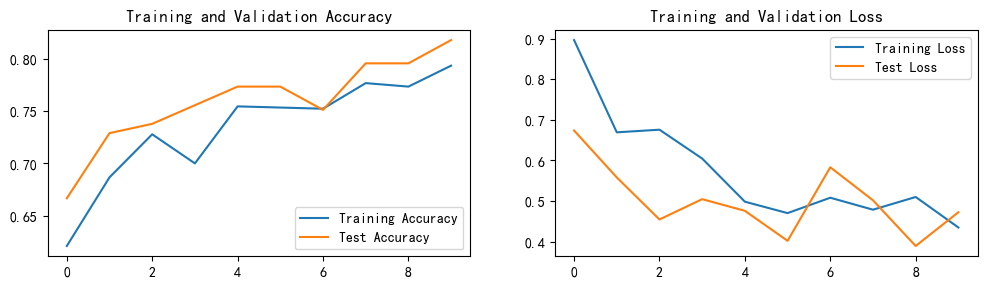

In [17]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
def recognize_local_pic(pic_path, model):
    classes = ['cloudy', 'rain', 'shine', 'sunrise']
    model.to('cpu')
    img = PIL.Image.open(pic_path)
    train_transforms  = transforms.Compose([
    transforms.Resize([128, 128]),  # 将输入图片resize成统一尺寸
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的。
])
    img = train_transforms(img)
    img = img.reshape((1,3,128,128))
    label = classes[torch.argmax(model(img),dim=1)]
    plt.imshow(np.array(PIL.Image.open(pic_path)))
    plt.title(label)
    plt.axis('off')
    return label

'cloudy'

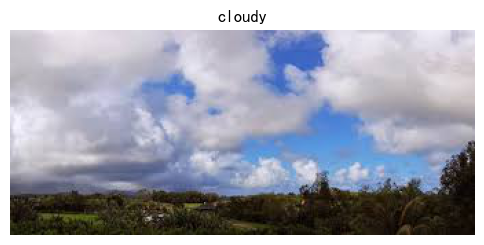

In [19]:
pic_path = 'data/weather_photos/cloudy/cloudy101.jpg'
recognize_local_pic(pic_path, model)

## VGG
VGG是Oxford的Visual Geometry Group的组提出的（大家应该能看出VGG名字的由来了）。该网络是在ILSVRC 2014上的相关工作，主要工作是证明了增加网络的深度能够在一定程度上影响网络最终的性能。VGG有两种结构，分别是VGG16和VGG19，两者并没有本质上的区别，只是网络深度不一样。



### VGG原理

VGG16相比AlexNet的一个改进是采用连续的几个3x3的卷积核代替AlexNet中的较大卷积核（11x11，7x7，5x5）。对于给定的感受野（与输出有关的输入图片的局部大小），采用堆积的小卷积核是优于采用大的卷积核，因为多层非线性层可以增加网络深度来保证学习更复杂的模式，而且代价还比较小（参数更少）。



简单来说，在VGG中，使用了3个3x3卷积核来代替7x7卷积核，使用了2个3x3卷积核来代替5*5卷积核，这样做的主要目的是在保证具有相同感知野的条件下，提升了网络的深度，在一定程度上提升了神经网络的效果。



比如，3个步长为1的3x3卷积核的一层层叠加作用可看成一个大小为7的感受野（其实就表示3个3x3连续卷积相当于一个7x7卷积），其参数总量为 3x(9xC^2) ，如果直接使用7x7卷积核，其参数总量为 49xC^2 ，这里 C 指的是输入和输出的通道数。很明显，27xC^2小于49xC^2，即减少了参数；而且3x3卷积核有利于更好地保持图像性质。

## 优缺点

VGG优点

VGGNet的结构非常简洁，整个网络都使用了同样大小的卷积核尺寸（3x3）和最大池化尺寸（2x2）。
几个小滤波器（3x3）卷积层的组合比一个大滤波器（5x5或7x7）卷积层好：
验证了通过不断加深网络结构可以提升性能。


VGG缺点

VGG耗费更多计算资源，并且使用了更多的参数（这里不是3x3卷积的锅），导致更多的内存占用（140M）。其中绝大多数的参数都是来自于第一个全连接层。VGG可是有3个全连接层啊！
PS：有的文章称：发现这些全连接层即使被去除，对于性能也没有什么影响，这样就显著降低了

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [23]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [45]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [46]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

In [47]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [48]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [49]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [50]:
OUTPUT_DIM = len(dataset.classes)

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [51]:
model=model.to(device)

['cloudy', 'rain', 'shine', 'sunrise']
1125


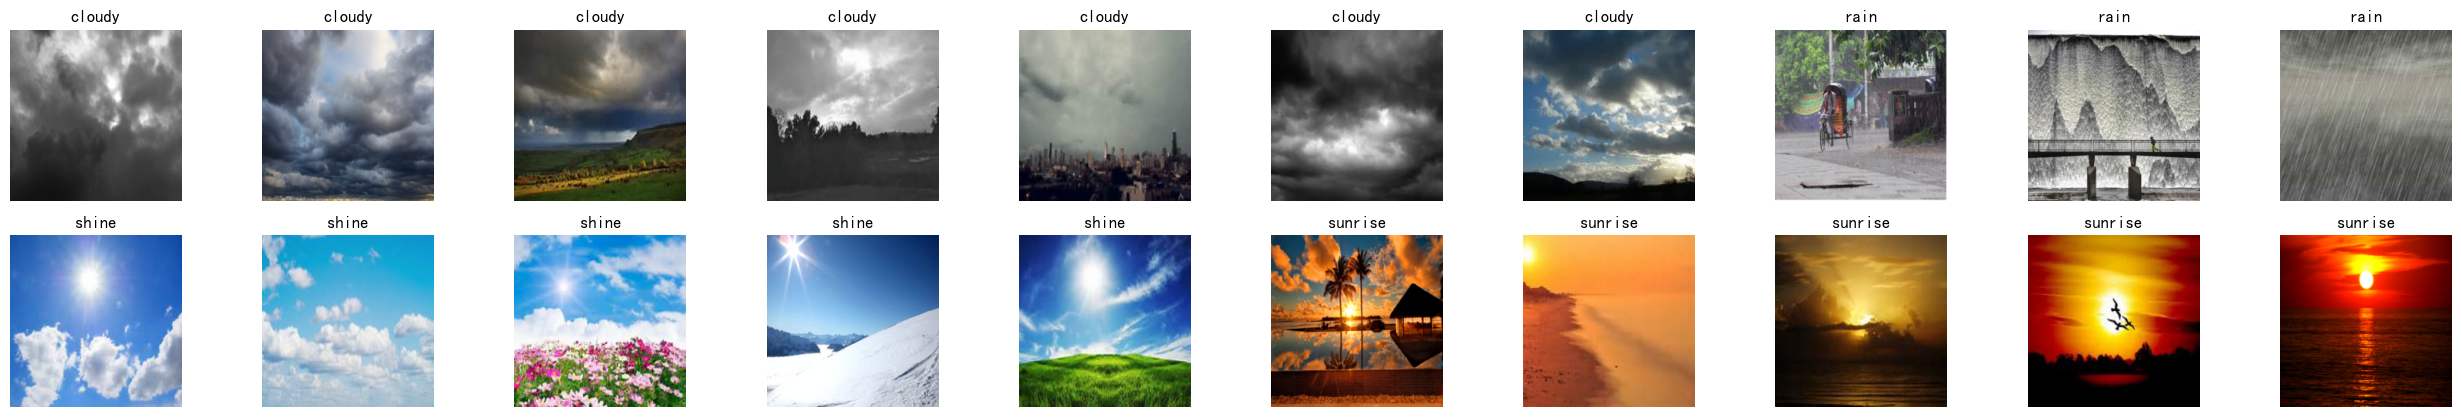

In [52]:
data_dir = 'data/weather_photos/'
train_transforms  = transforms.Compose([
    transforms.Resize([224, 224]),  # 将输入图片resize成统一尺寸
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的。
])
############这里尝试做过灰度显示以后进行训练，但是结果是不如人意的，增加模型层数也达不到90%的进度，只能到88%左右，通过图片也能看出来，如果没有颜色的话，shine和sunrise其实还是不好判断的。


dataset = datasets.ImageFolder(data_dir,transform=train_transforms)
print(dataset.classes)
print(len(dataset))
import matplotlib.pyplot as plt
import numpy as np
means=[0.485, 0.456, 0.406]
stds=[0.229, 0.224, 0.225]
plt.figure(figsize=(32,5))
for i in range(20):
    k =  np.random.randint(40,60)
    img = dataset[k*i+i][0].numpy().transpose((1,2,0))
    img = img*stds + means
    img = np.clip(img, 0, 1)
    plt.subplot(2, 10, i+1)
    plt.imshow(img,cmap = plt.cm.gray_r)
    # 增加对应图片的标题
    plt.title(dataset.classes[dataset[k*i+i][1]])
    plt.axis('off')

In [53]:
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset, test_dataset

batch_size = 32

train_dl = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [54]:
run = wandb.init(project="基于VGG进行天气识别")

wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [55]:
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数
learn_rate = 1e-3 # 学习率
opt        = torch.optim.Adam(model.parameters(),lr=learn_rate, weight_decay=1e-4)
epochs     = 10
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,epochs, last_epoch=-1) 
best_acc =[0, 0.0]
wandb.watch(model, loss_fn, log="all", log_freq=10) # WANDB WATCH

[]

In [56]:
for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt, lr_scheduler)
    if best_acc[1] <  epoch_train_acc:
        best_acc =[epoch, epoch_train_acc]
        best_model_wst = copy.deepcopy(model.state_dict())

    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    wandb.log({"loss":epoch_train_loss, "acc":epoch_train_acc, "val_loss": epoch_test_loss, "val_acc":epoch_test_acc}, step=epoch)
    wandb.log({"eoch lr":lr_scheduler.get_lr()[0]}, step=epoch)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print("*"*20, 'Done', "*"*20)
print("best_acc= ", best_acc)

learning rate =  0.0009755282581475768
Epoch: 1, Train_acc:35.4%, Train_loss:7.882, Test_acc:50.7%，Test_loss:1.190
learning rate =  0.0009045084971874736
Epoch: 2, Train_acc:51.7%, Train_loss:1.296, Test_acc:41.8%，Test_loss:2.739
learning rate =  0.0007938926261462366
Epoch: 3, Train_acc:55.7%, Train_loss:1.036, Test_acc:72.4%，Test_loss:1.092
learning rate =  0.0006545084971874737
Epoch: 4, Train_acc:64.8%, Train_loss:1.029, Test_acc:80.9%，Test_loss:0.443
learning rate =  0.0005
Epoch: 5, Train_acc:66.3%, Train_loss:1.538, Test_acc:74.2%，Test_loss:0.583
learning rate =  0.00034549150281252633
Epoch: 6, Train_acc:64.4%, Train_loss:0.905, Test_acc:79.1%，Test_loss:0.530
learning rate =  0.0002061073738537635
Epoch: 7, Train_acc:70.7%, Train_loss:1.114, Test_acc:75.6%，Test_loss:0.589
learning rate =  9.549150281252634e-05
Epoch: 8, Train_acc:73.6%, Train_loss:0.903, Test_acc:78.2%，Test_loss:0.674
learning rate =  2.4471741852423235e-05
Epoch: 9, Train_acc:76.3%, Train_loss:0.626, Test_acc:

In [57]:
run.finish() # 上传报告

acc,▁▄▄▆▆▆▇▇██
eoch lr,█▇▆▅▄▃▂▁▁▁
loss,█▂▁▁▂▁▂▁▁▁
val_acc,▃▁▆█▇█▇███
val_loss,▃█▃▁▁▁▁▂▁▂
acc,0.78889
eoch lr,0.0
loss,0.56417
val_acc,0.8
val_loss,0.73177
